# Research Part B - Optimising Call Center Operation

This part shows the **hyperparameters and reward structure** for the reinforcement learning agent. The goal is to train an agent to make optimal decisions in assigning customer service requests.


In [1]:

# ==== Hyperparameters & Rewards (static) ====
MAX_Q1 = 20
MAX_Q2 = 20
MAX_SKILLED = 10
MAX_NORMAL  = 10

REWARD_SERVE_IMPORTANT = 5.0
REWARD_SERVE_NORMAL    = 3.0
PENALTY_IDLE_AGENT     = -1.0
PENALTY_WAITING_CUSTOMER = -2.0   
PENALTY_MISMATCH       = -2.0
INVALID_ACTION_PENALTY = -2.0

ACTIONS = {
    0: "Assign important to Skilled Agent",
    1: "Assign normal to Normal Agent",
    2: "Assign important to Normal Agent",
    3: "Assign normal to Skilled Agent",
    4: "Do nothing"
}

# Q-learning
ALPHA   = 0.1
GAMMA   = 0.95
EPSILON_START = 0.2
EPSILON_END   = 0.01
EPISODES = 200                
SIM_DURATION = 60*60        
SEED = 321


This part is for **data loading and preprocessing**. It process the dataset "Updateddata1999july.csv".

Tasks performed:

1.  **Loading the Data**
2.  **Identifying and Standardizing Columns**: Finds key columns (like `server`, `ser_time`, `call_id`)
3.  **Cleaning and Converting Data Types**: All columns are in the correct format (e.g., converting text to uppercase, converting columns to strings or numbers).
4.  **Creating a New Feature**: Generates the `is_important` feature, crucial for categorizing calls and creating logic.

In [2]:

import pandas as pd, numpy as np, math
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from pathlib import Path
from statistics import mean

DATA_PATH = Path("Updateddata1999july.csv")
df_raw = pd.read_csv(DATA_PATH)

def pick(opts, cols):
    for c in opts:
        if c in cols:
            return c
    return None

cols = df_raw.columns.tolist()
col_server   = pick(["server"], col)
col_type     = pick(["type"], cols)
col_ser_time = pick(["ser_time"], cols)
col_call_id  = pick(["call_id"], cols)
col_customer = pick(["customer_id"], cols)
col_priority = pick(["priority"], cols) 

need = [col_server, col_ser_time, col_call_id]
if any(v is None for v in need):
    raise ValueError(f"Missing required columns. Found: {cols}\nNeed at least server, ser_time, call_id.")

keep = [col_server, col_ser_time, col_call_id]
if col_type:     keep.append(col_type)
if col_priority: keep.append(col_priority)
if col_customer: keep.append(col_customer)

df = df_raw[keep].copy()
rename = {col_server:"server", col_ser_time:"ser_time", col_call_id:"call_id"}
if col_type:     rename[col_type]     = "type"
if col_priority: rename[col_priority] = "priority_raw"
if col_customer: rename[col_customer] = "customer_id"
df.rename(columns=rename, inplace=True)

df["server"] = df["server"].astype(str)
df["call_id"] = df["call_id"].astype(str)
if "customer_id" in df.columns:
    df["customer_id"] = df["customer_id"].astype(str)
if "type" in df.columns:
    df["type"] = df["type"].astype(str).str.upper()

def to_seconds(x):
    try:
        v = float(x)
        return v*60.0 if v < 20 else v
    except:
        return np.nan
df["ser_time"] = df["ser_time"].apply(to_seconds)
mask = df["ser_time"].isna()
if mask.any():
    rng = np.random.default_rng(7)
    df.loc[mask,"ser_time"] = np.clip(rng.lognormal(mean=np.log(180), sigma=0.6, size=mask.sum()), 30, 3600)


if "type" in df.columns:
    df["is_important"] = df["type"].str.contains("PS", regex=False).astype(int)
else:
    def to_int(v):
        try: return int(v)
        except: return 0
    df["priority_raw"] = df["priority_raw"].apply(to_int) if "priority_raw" in df.columns else 0
    df["is_important"] = (df["priority_raw"]>=1).astype(int)

print("Dataset preview:")
df.head(10)

Dataset preview:


,server,ser_time,call_id,type,priority_raw,customer_id,is_important
0,MORIAH,480.0,41887,NW,0,0,0
1,MORIAH,221.0,41888,PS,0,0,1
2,ANAT,82.0,41889,PS,2,22800312,1
3,KAZAV,78.0,41890,PS,0,0,1
4,YIFAT,588.0,41891,PS,0,0,1
5,TOVA,55.0,41892,PS,1,58803644,1
6,KAZAV,121.0,41894,PS,1,55387302,1
7,BASCH,171.0,41895,PS,2,32389629,1
8,BASCH,46.0,41897,PS,2,15239874,1
9,KAZAV,405.0,41898,NE,2,12482634,0


## Exploratory Data Analysis (EDA)

This part performs exploratory data analysis (EDA) to summarize key points of dataset. It provides insights into data size, # of unique servers, the mix of important vs normal calls and metrics for service times.

In [3]:

print("Rows:", len(df))
print("Unique servers:", df['server'].nunique())
print("Priority mix (from type/priority):")
print(df['is_important'].value_counts(normalize=True).rename({0:'normal',1:'important'}))

# Service-time stats
desc = df['ser_time'].describe(percentiles=[0.5,0.9,0.95,0.99]).to_frame().T
desc


Rows: 26530
Unique servers: 20
Priority mix (from type/priority):
is_important
important    0.740068
normal       0.259932
Name: proportion, dtype: float64


,count,mean,std,min,50%,90%,95%,99%,max
ser_time,26530.0,177.062118,159.135416,20.0,124.0,380.0,487.0,840.0,1140.0


This part shows **histograms to show the distribution** of service times. It creates one histogram for all calls and a second one to compare the distributions for **important vs normal calls.**, helps in understanding the data characteristics.

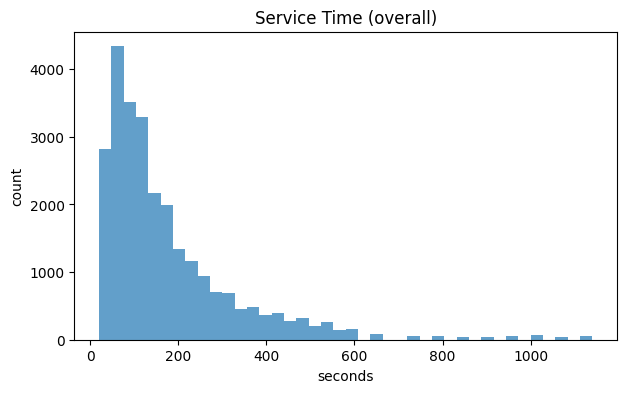

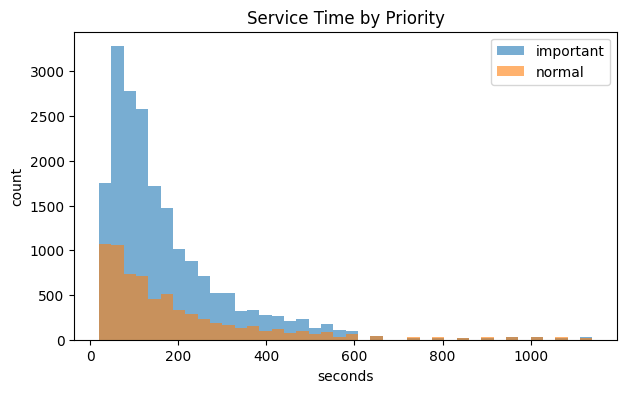

In [4]:

# Histograms: service time overall and by priority
fig, ax = plt.subplots(figsize=(7,4))
df['ser_time'].plot(kind='hist', bins=40, alpha=0.7, ax=ax)
ax.set_title("Service Time (overall)")
ax.set_xlabel("seconds"); ax.set_ylabel("count")
plt.show()

fig, ax = plt.subplots(figsize=(7,4))
df[df["is_important"]==1]["ser_time"].plot(kind="hist", bins=40, alpha=0.6, ax=ax)
df[df["is_important"]==0]["ser_time"].plot(kind="hist", bins=40, alpha=0.6, ax=ax)
ax.set_title("Service Time by Priority")
ax.set_xlabel("seconds"); ax.set_ylabel("count")
ax.legend(["important","normal"])
plt.show()


**Top 15 servers** by volume and their mean service time

In [5]:

# Top 15 servers by volume and their mean service time
top_srv = (df.groupby('server')
             .agg(calls=('server','count'),
                  mean_ser=('ser_time','mean'),
                  important_ratio=('is_important','mean'))
             .sort_values('calls', ascending=False)
             .head(15))
top_srv


,calls,mean_ser,important_ratio
server,,,
AVI,2742,149.526988,0.708242
SHARON,2490,153.635341,0.738956
MORIAH,2306,197.935820,0.705551
AVNI,1943,205.194030,0.752959
TOVA,1837,168.600980,0.766467
ROTH,1714,188.665694,0.824387
KAZAV,1689,166.506809,0.770870
BENSION,1663,142.078773,0.740229
ANAT,1442,183.070042,0.823856


Boxplot of service time by priority **(capped at 95 percentile to avoid extreme tails)**

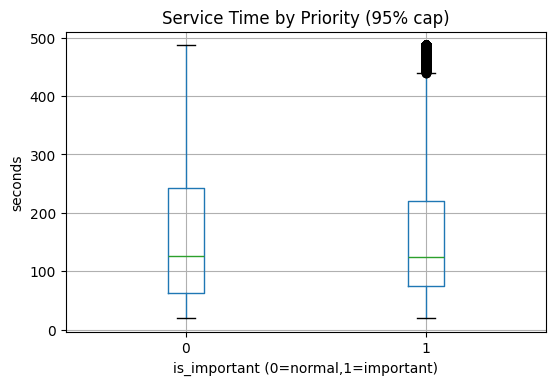

In [6]:

# Boxplot of service time by priority (capped at 95th percentile to avoid extreme tails)
cap = df['ser_time'].quantile(0.95)
fig, ax = plt.subplots(figsize=(6,4))
df2 = df.assign(ser_capped=df['ser_time'].clip(upper=cap))
df2.boxplot(column='ser_capped', by='is_important', ax=ax)
ax.set_title("Service Time by Priority (95% cap)"); ax.set_xlabel("is_important (0=normal,1=important)"); ax.set_ylabel("seconds")
plt.suptitle("")
plt.show()


This part shows the **preprocessed data to categorise agents based on their performance**, specifically the **ratio of crucial calls** they manage. It selects the top performing agents as **skilled** and the rest as **normal**. This is a important step for setting up the agent hierarchy.

In [7]:

# Agent profiling -> Skilled vs Normal
agent_stats = (
    df.groupby("server")
      .agg(calls=("server","count"),
           important_ratio=("is_important","mean"),
           mean_ser_time=("ser_time","mean"))
      .sort_values("important_ratio", ascending=False)
)

top_k = max(1, int(len(agent_stats)*0.2))
skilled_names = agent_stats.head(top_k).index.tolist()
normal_names  = agent_stats.index.difference(skilled_names).tolist()

skilled_cnt = min(MAX_SKILLED, max(1, len(skilled_names)))
normal_cnt  = min(MAX_NORMAL,  max(1, len(normal_names)))

skilled_names = skilled_names[:skilled_cnt]
normal_names  = normal_names[:normal_cnt]

print("Skilled:", skilled_names)
print("Normal :", normal_names)


Skilled: ['DORIT', 'NAAMA', 'ROTH', 'ANAT']
Normal : ['AVI', 'AVNI', 'BASCH', 'BENSION', 'ELI', 'GILI', 'KAZAV', 'MORIAH', 'PINHAS', 'SHARON']


This part calculates **call arrival rate** based on a **target agent utilization.** This ensures that the **simulation environment** is realistically developed with arrival rate balancing service capacity of agents(server) to achieve the desired utilization level. Arrival rate from utilization target **(65% by default)**

In [8]:

# Arrival rate from utilization target (65% by default)
TARGET_UTIL = 0.65
mu = float(df['ser_time'].mean())
A = skilled_cnt + normal_cnt
service_rate = A / mu if mu>0 else 0.01
LAMBDA = TARGET_UTIL * service_rate
p_imp = float(df['is_important'].mean())

print(f"mu={mu:.1f}s, agents={A}, rate={service_rate:.4f}/s, lambda={LAMBDA:.4f}/s, p_imp={p_imp:.2f}")


mu=177.1s, agents=14, rate=0.0791/s, lambda=0.0514/s, p_imp=0.74


This section prepares a simplified **dataset** for the simulation by extracting the **essential call information (ID, service time and priority)**. It also ensures that all call IDs are unique, which is a critical step for event based simulations, by appending an index to any duplicated IDs.

In [9]:

# Base call templates for arrivals
base_calls = df[['call_id','ser_time','is_important']].copy().reset_index(drop=True)
if base_calls['call_id'].duplicated().any():
    base_calls['call_id'] = [f"{cid}_{i}" for i, cid in enumerate(base_calls['call_id'])]
base_calls.head(3)

,call_id,ser_time,is_important
0,41887_0,480.0,0
1,41888_1,221.0,1
2,41889_2,82.0,1


This part shows the `CallCenterEnv` class, which is the core simulation environment for the reinforcement learning problem. It models the call center dynamics, including call arrivals, queue management, agent states, and the progression of time. The class methods handle actions taken by the reinforcement learning agent and update the environment's state, returning the resulting new state and reward.

In [10]:

# Environment capturing per-second queue series for heatmaps
class CallCenterEnv:
    def __init__(self, skilled_names, normal_names, LAMBDA, p_imp, seed=SEED):
        self.skilled_names = list(skilled_names)
        self.normal_names  = list(normal_names)
        self.S = len(self.skilled_names)
        self.N = len(self.normal_names)
        self.LAMBDA = LAMBDA
        self.p_imp  = p_imp
        self.rng = np.random.default_rng(seed)
        self.reset()

    def reset(self):
        self.t = 0
        self.skilled = {name: {"rem":0.0, "call_id":None} for name in self.skilled_names}
        self.normal  = {name: {"rem":0.0, "call_id":None} for name in self.normal_names}
        self.q1 = deque()
        self.q2 = deque()
        self.rewards = []
        self.assign_log = []
        # For heatmaps:
        self.q1_series = []
        self.q2_series = []
        return self._state()

    def _state(self):
        freeS = sum(1 for v in self.skilled.values() if v["rem"]<=0.0)
        freeN = sum(1 for v in self.normal.values()  if v["rem"]<=0.0)
        return (min(len(self.q1), MAX_Q1), min(len(self.q2), MAX_Q2),
                min(freeS, MAX_SKILLED), min(freeN, MAX_NORMAL))

    def _inject_arrivals(self):
        k = self.rng.poisson(self.LAMBDA)
        for _ in range(k):
            i = self.rng.integers(0, len(base_calls))
            rec = base_calls.iloc[i]
            call = {"call_id": f"{rec['call_id']}_{self.t}", "ser_time": float(rec['ser_time'])}
            if self.rng.uniform() < self.p_imp:
                self.q1.append(call)
            else:
                self.q2.append(call)

    def _advance_1s(self):
        for name, slot in self.skilled.items():
            if slot["rem"]>0.0:
                slot["rem"] = max(0.0, slot["rem"]-1.0)
                if slot["rem"]==0.0:
                    slot["call_id"]=None
        for name, slot in self.normal.items():
            if slot["rem"]>0.0:
                slot["rem"] = max(0.0, slot["rem"]-1.0)
                if slot["rem"]==0.0:
                    slot["call_id"]=None

    def _assign(self, queue, pool_dict, label):
        if not queue: return False, None, None
        for name, slot in pool_dict.items():
            if slot["rem"]<=0.0:
                c = queue.popleft()
                slot["rem"] = c["ser_time"]
                slot["call_id"] = c["call_id"]
                return True, name, c["call_id"]
        return False, None, None

    def step(self, action):
        self._inject_arrivals()

        # Per non-empty queue waiting penalty
        reward = 0.0
        if len(self.q1)>0: reward += PENALTY_WAITING_CUSTOMER
        if len(self.q2)>0: reward += PENALTY_WAITING_CUSTOMER

        valid = True
        if action == 0:
            ok, agent, cid = self._assign(self.q1, self.skilled, "skilled")
            if ok:
                reward += REWARD_SERVE_IMPORTANT
                self.assign_log.append({"t":self.t,"action":0,"used_queue":"Q1(imp)","agent_type":"skilled","agent":agent,"call_id":cid})
            else:
                valid = False
        elif action == 1:
            ok, agent, cid = self._assign(self.q2, self.normal, "normal")
            if ok:
                reward += REWARD_SERVE_NORMAL
                self.assign_log.append({"t":self.t,"action":1,"used_queue":"Q2(norm)","agent_type":"normal","agent":agent,"call_id":cid})
            else:
                valid = False
        elif action == 2:
            ok, agent, cid = self._assign(self.q1, self.normal, "normal")
            if ok:
                reward += REWARD_SERVE_IMPORTANT + PENALTY_MISMATCH
                self.assign_log.append({"t":self.t,"action":2,"used_queue":"Q1(imp)","agent_type":"normal (mismatch)","agent":agent,"call_id":cid})
            else:
                valid = False
        elif action == 3:
            ok, agent, cid = self._assign(self.q2, self.skilled, "skilled")
            if ok:
                reward += REWARD_SERVE_NORMAL + PENALTY_MISMATCH
                self.assign_log.append({"t":self.t,"action":3,"used_queue":"Q2(norm)","agent_type":"skilled (mismatch)","agent":agent,"call_id":cid})
            else:
                valid = False
        elif action == 4:
            pass
        else:
            valid = False

        if not valid:
            reward += INVALID_ACTION_PENALTY

        # Idle penalty per free agent
        freeS = sum(1 for v in self.skilled.values() if v["rem"]<=0.0)
        freeN = sum(1 for v in self.normal.values()  if v["rem"]<=0.0)
        reward += PENALTY_IDLE_AGENT * (freeS + freeN)

        self._advance_1s()
        self.t += 1
        self.rewards.append(reward)

        # record series for heatmaps
        self.q1_series.append(len(self.q1))
        self.q2_series.append(len(self.q2))

        return self._state(), reward


This code implement core logic for reinforcement learning agent, including a baseline **greedy policy** and **Q learning algorithm**.

The `greedy_action` function shows a simple non learning policy that makes the best possible assignment decision at every step based on immediate

**conditions**:

The `run_policy` function is a utility for executing simulation given any policy function **(greedy or learned)** and collecting performance data.

The `epsilon_at` function shows the decay schedule for the exploration rate, which is a key component of the Q learning algorithm.

The `q_learning` function is the main training loop. It initializes the **Q table** and iteratively updates it using the **Bellman equation** balancing exploration and exploitation to learn an optimal policy.

In [11]:

def greedy_action(state):
    q1,q2,fS,fN = state
    if q1>0 and fS>0: return 0
    if q2>0 and fN>0: return 1
    if q1>0 and fN>0: return 2
    if q2>0 and fS>0: return 3
    return 4

def run_policy(env, policy_fn, T=SIM_DURATION, capture_actions=False):
    s = env.reset()
    actions = []
    feasible = []  # decision opportunity flags
    for _ in range(T):
        # is there a feasible assignment?
        q1,q2,fS,fN = s
        feas = ( (q1>0 and (fS>0 or fN>0)) or (q2>0 and (fS>0 or fN>0)) )
        a = policy_fn(s)
        s, _ = env.step(a)
        if capture_actions:
            actions.append(a)
            feasible.append(1 if feas else 0)
    return env, actions, feasible

# Epsilon decay schedule
def epsilon_at(ep):
    if EPISODES<=1: return EPSILON_END
    frac = ep/(EPISODES-1)
    return float(EPSILON_START + (EPSILON_END-EPSILON_START)*frac)

def q_learning(skilled_names, normal_names, LAMBDA, p_imp):
    Q = defaultdict(lambda: np.zeros(5, dtype=np.float32))
    rng_local = np.random.default_rng(SEED)
    returns = []
    for ep in range(EPISODES):
        eps = epsilon_at(ep)
        env = CallCenterEnv(skilled_names, normal_names, LAMBDA, p_imp, seed=SEED+ep)
        s = env.reset()
        G = 0.0
        for _ in range(SIM_DURATION):
            if rng_local.uniform() < eps:
                a = rng_local.integers(0,5)
            else:
                a = int(np.argmax(Q[s]))
            s2, r = env.step(a)
            G += r
            Q[s][a] = (1-ALPHA)*Q[s][a] + ALPHA*(r + GAMMA*np.max(Q[s2]))
            s = s2
        returns.append(G)
    def policy(state): return int(np.argmax(Q[state]))
    return policy, returns


This part execute call center simulation using two different policies, simple rule based **greedy policy** and **learned Q learning policy**. It uses `run_policy` function to execute each simulation and capture sequence of actions.

In [12]:

# Run Greedy and Q-learning
env_g, g_actions, g_feasible = run_policy(CallCenterEnv(skilled_names, normal_names, LAMBDA, p_imp, seed=SEED),
                                          greedy_action, capture_actions=True)
pi, returns = q_learning(skilled_names, normal_names, LAMBDA, p_imp)
env_q, q_actions, q_feasible = run_policy(CallCenterEnv(skilled_names, normal_names, LAMBDA, p_imp, seed=SEED+999),
                                          pi, capture_actions=True)

print("Done.")

Done.


This part plots **convergence of Qlearning algorithm**, Calculates a **moving average** of the returns over episodes to smooth the data and clearly show trend of the agent's performance improvement over time. A converging learning curve indicates that the agent is successfully learning an effective policy.

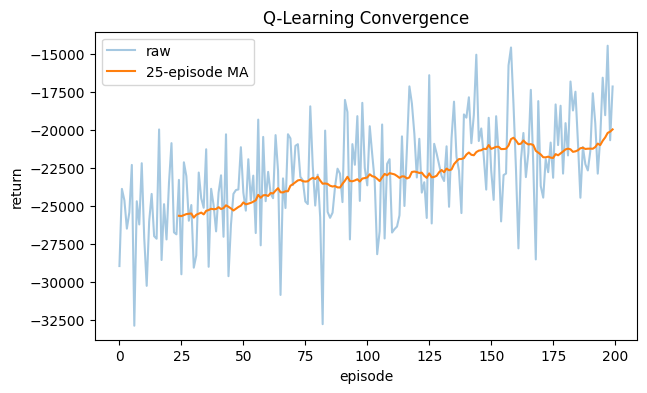

In [13]:

# Convergence with moving average (window=25)
def moving_avg(x, w=25):
    import numpy as np
    if len(x)<w: return np.array(x)
    c = np.cumsum(np.insert(x,0,0))
    return (c[w:]-c[:-w])/float(w)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(returns, alpha=0.4, label="raw")
ma = moving_avg(returns, 25)
ax.plot(range(25-1, 25-1+len(ma)), ma, label="25-episode MA")
ax.set_title("Q-Learning Convergence"); ax.set_xlabel("episode"); ax.set_ylabel("return")
ax.legend(); plt.show()


This part shows and compare the distribution of actions taken by the **greedy policy and the learned Q learning policy**. It generates bar charts showing the frequency of each action, for every step **("all ticks")** and specifically during moments when a decision to assign a call was possible **("decision opportunities")**. This analysis shows insight into how every policy behaves and where their strategies differ.

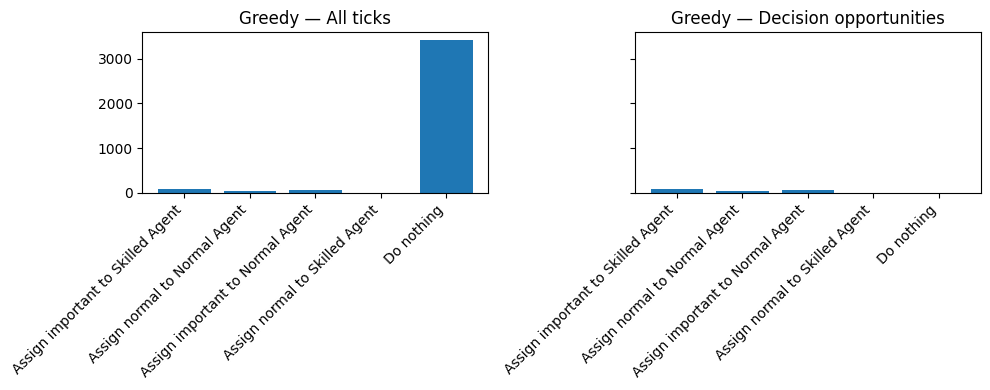

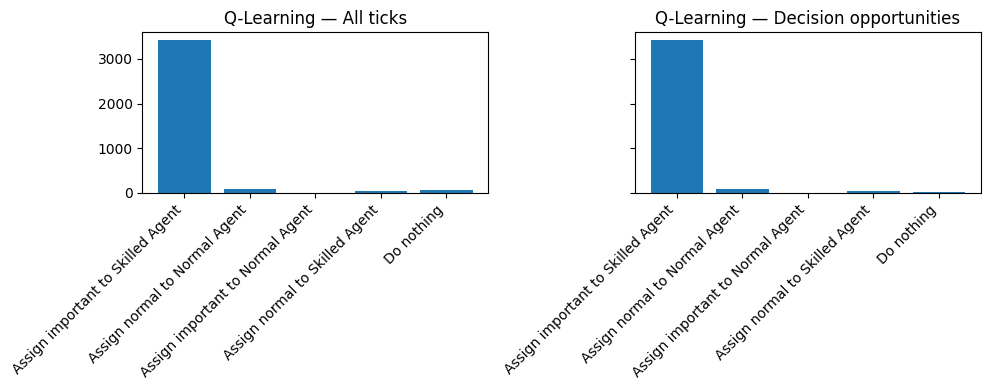

In [14]:

# Action distributions: all ticks vs decision opportunities only
import numpy as np, pandas as pd

def action_distribution(actions, feasible_flags):
    actions = np.array(actions)
    feas = np.array(feasible_flags)
    all_counts = pd.Series(actions).value_counts().reindex(range(5), fill_value=0)
    feas_counts = pd.Series(actions[feas==1]).value_counts().reindex(range(5), fill_value=0)
    return all_counts, feas_counts

g_all, g_feas = action_distribution(g_actions, g_feasible)
q_all, q_feas = action_distribution(q_actions, q_feasible)

fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
axes[0].bar(range(5), g_all.values); axes[0].set_title("Greedy — All ticks"); axes[0].set_xticks(range(5), list(ACTIONS.values()), rotation=45, ha='right')
axes[1].bar(range(5), g_feas.values); axes[1].set_title("Greedy — Decision opportunities"); axes[1].set_xticks(range(5), list(ACTIONS.values()), rotation=45, ha='right')
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
axes[0].bar(range(5), q_all.values); axes[0].set_title("Q-Learning — All ticks"); axes[0].set_xticks(range(5), list(ACTIONS.values()), rotation=45, ha='right')
axes[1].bar(range(5), q_feas.values); axes[1].set_title("Q-Learning — Decision opportunities"); axes[1].set_xticks(range(5), list(ACTIONS.values()), rotation=45, ha='right')
plt.tight_layout(); plt.show()


This part creates and shows **heatmaps to visualize queue length**. It reshapes the persecond **queue data into a 60x60 grid**, representing minutes by seconds for both the greedy and Q learning policies.

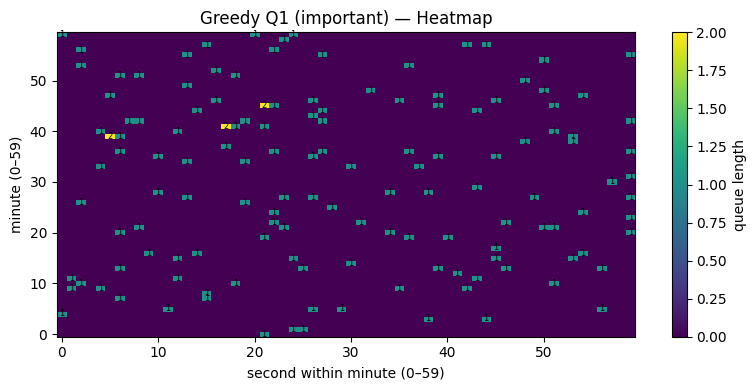

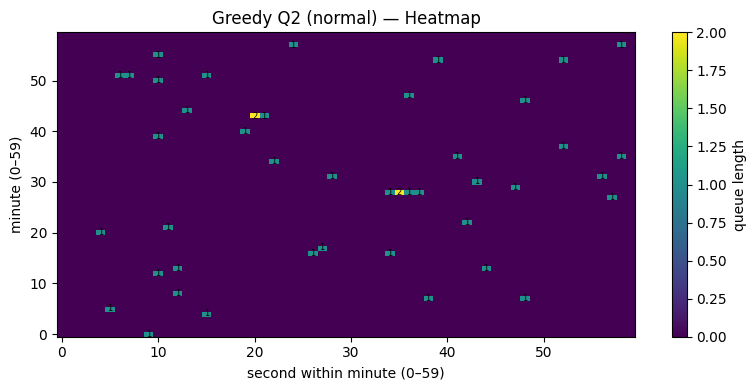

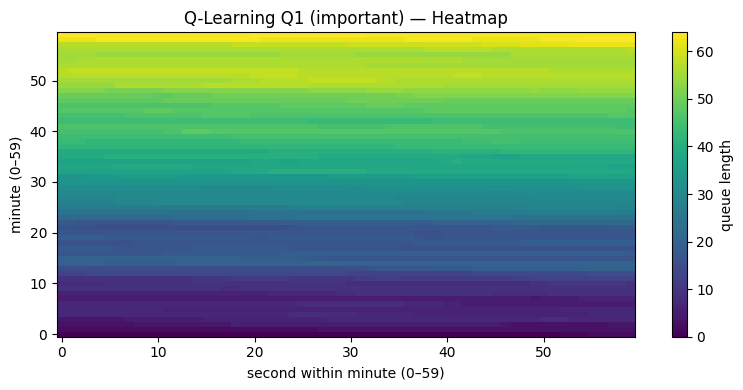

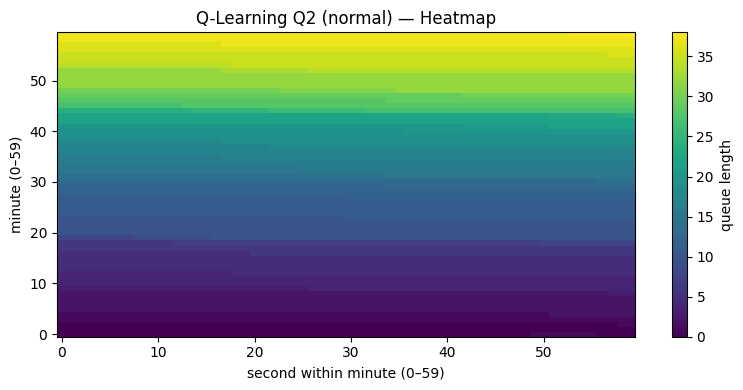

In [15]:

# === Queue heatmaps ===
import numpy as np

def queue_heatmap(q_series, title, annotate=False):
    # reshape 3600 seconds into 60 x 60 (min x sec)
    a = np.array(q_series[:3600], dtype=float)
    if a.size < 3600:
        a = np.pad(a, (0, 3600 - a.size), constant_values=0)
    grid = a.reshape(60, 60)
    vmax = max(1.0, float(np.nanmax(grid)))
    fig, ax = plt.subplots(figsize=(8,4))
    im = ax.imshow(grid, aspect='auto', origin='lower', vmin=0.0, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel("second within minute (0–59)")
    ax.set_ylabel("minute (0–59)")
    cbar = fig.colorbar(im, ax=ax, label="queue length")
    # optional annotations (only if values modest, to avoid clutter)
    if annotate and vmax <= 10:
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                v = int(grid[i,j])
                if v>0:
                    ax.text(j, i, str(v), ha='center', va='center', fontsize=6)
    plt.tight_layout()
    plt.show()

queue_heatmap(env_g.q1_series, "Greedy Q1 (important) — Heatmap", annotate=True)
queue_heatmap(env_g.q2_series, "Greedy Q2 (normal) — Heatmap", annotate=True)
queue_heatmap(env_q.q1_series, "Q-Learning Q1 (important) — Heatmap", annotate=True)
queue_heatmap(env_q.q2_series, "Q-Learning Q2 (normal) — Heatmap", annotate=True)


This part plots the **cumulative reward of greedy and Q learning policies** over time to visually compare their performance. It also generates a summary table to provide a **comparison of the total and average reward per second for each policy**, offering a clear measure of their effectiveness.

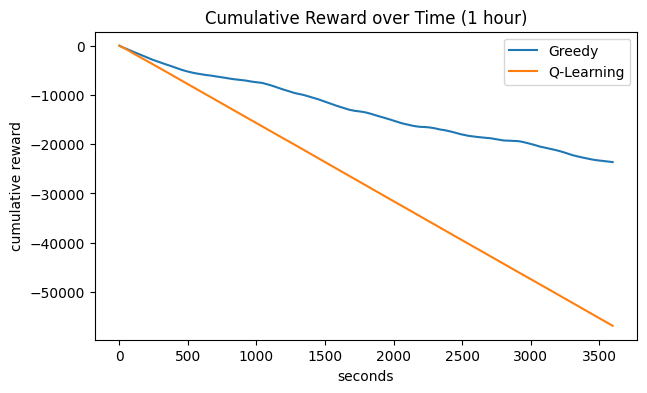

,policy,total_reward,avg_reward_per_sec
0,Greedy,-23628.0,-6.563333
1,Q-Learning,-56847.0,-15.790833


In [16]:

# Cumulative reward curves for the last evaluation episodes
def cumulative(xs):
    out, s = [], 0.0
    for v in xs:
        s += v; out.append(s)
    return out

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(cumulative(env_g.rewards), label="Greedy")
ax.plot(cumulative(env_q.rewards), label="Q-Learning")
ax.set_title("Cumulative Reward over Time (1 hour)")
ax.set_xlabel("seconds"); ax.set_ylabel("cumulative reward")
ax.legend(); plt.show()

# Summary table
import pandas as pd
summary = pd.DataFrame({
    "policy": ["Greedy","Q-Learning"],
    "total_reward": [sum(env_g.rewards), sum(env_q.rewards)],
    "avg_reward_per_sec": [mean(env_g.rewards), mean(env_q.rewards)]
})
summary



# First 25 call assignments

This part inspects and compares the **first 25 call assignments** made by both, **greedy and the Q learning policies**. By displaying these assignments side by side in a DataFrame, we can analyze the initial decisions of each policy and observe any **differences in their call routing strategy**.

In [17]:

import pandas as pd
assign_g = pd.DataFrame(env_g.assign_log).head(25)
assign_q = pd.DataFrame(env_q.assign_log).head(25)
print("== First 25 Assignments (Greedy) =="); display(assign_g)
print("== First 25 Assignments (Q-Learning) =="); display(assign_q)


== First 25 Assignments (Greedy) ==


,t,action,used_queue,agent_type,agent,call_id
0,10,1,Q2(norm),normal,AVI,33484_2298_9
1,22,0,Q1(imp),skilled,DORIT,22284_10204_21
2,85,0,Q1(imp),skilled,NAAMA,45476_12630_84
3,86,0,Q1(imp),skilled,ROTH,44525_15165_85
4,219,0,Q1(imp),skilled,ROTH,43244_14796_218
5,225,0,Q1(imp),skilled,NAAMA,44285_5795_224
6,241,0,Q1(imp),skilled,ANAT,22194_25612_240
7,256,1,Q2(norm),normal,AVI,45515_12654_255
8,306,1,Q2(norm),normal,AVNI,6309_19078_305
9,312,0,Q1(imp),skilled,NAAMA,43825_5472_311


== First 25 Assignments (Q-Learning) ==


,t,action,used_queue,agent_type,agent,call_id
0,56,1,Q2(norm),normal,AVI,44788_15324_49
1,86,3,Q2(norm),skilled (mismatch),DORIT,7251_19739_86
2,139,0,Q1(imp),skilled,NAAMA,42420_23041_52
3,166,0,Q1(imp),skilled,ROTH,44605_13730_55
4,167,0,Q1(imp),skilled,ANAT,42959_14612_87
5,233,0,Q1(imp),skilled,NAAMA,42819_20445_128
6,271,0,Q1(imp),skilled,DORIT,37214_6540_138
7,277,0,Q1(imp),skilled,ROTH,42355_22994_138
8,311,0,Q1(imp),skilled,ANAT,46087_16909_177
9,396,0,Q1(imp),skilled,NAAMA,45660_12746_187
